## Objective: Understand the difference in the learning dynamic between spatial and conceptual
## Why?: It appears that the conceptual task with 3 inputs improves faster than the spatial task with 2 inputs when intuitively it should be more difficult

In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from tabulate import tabulate
from IPython.display import clear_output

import sys
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Models")
from Networks_v2 import Net_Individual
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Experimental_setup")
from Experiment_v5 import Experiment
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Training")
from Training_Networks_frozen_weights import Training_frozen_weights
sys.path.append("/Users/charlottebeylier/Documents/PhD/Spatial and Conceptual Learning/github_code/Mono_Multi_TASK/Analysis")
from Check import Checkup

sys.path.append("/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis")
from Manifold_Analysis import Manifold_analysis

from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets

In [2]:
def Display_Score(model,test_loader,epsilon,example,multi,spatial_task):
        length = 0
        score = 0
        for x_test,y_test in test_loader:
             with torch.no_grad():
                pumpkin_seed = np.int(x_test[0][5])
                if spatial_task:
                        x_test = x_test[:,0:2]
                else:
                    if not(multi):
                        x_test = x_test[:,2:5]
                    else:
                        x_test = x_test[:,0:5]
                yhat = torch.nn.Sigmoid()(model(x_test).squeeze(1))
                length += len(y_test)
                    
                for i in range(len(yhat)):
                    #take the prediction for the output node corresponding to either the conceptual or the spatial task
                    if multi:
                        if np.abs(yhat[i][pumpkin_seed] - y_test[i][pumpkin_seed] )<epsilon:
                            score+=1
                    else:
                        if np.abs(yhat[i]- y_test[i] )<epsilon:
                            score+=1


                if example:
                    if y_test[0]==1:
                        print("Data",x_test)
                        print("Target",y_test)
                        print("Prediction",yhat)
        print("Score final : ", (score/length)*100)

## Generate the Dataset

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


## Generate the Dataset

In [4]:
WIDTH = 100
BATCH_SIZE = 32
Nodes_Second = 10
Nodes_Third = 10
EPOCH = 50
ITERATION = 10

In [5]:
set_seed(seed=SEED)
experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE,size_output_multi=2)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()

Random seed 2021 has been set.
Test size dataset space torch.Size([999, 6])
Test size dataset weather torch.Size([999, 6])
Train size dataset space torch.Size([7000, 6])
Train size dataset weather torch.Size([7000, 6])


In [6]:
train_loader_weather = torch.utils.data.DataLoader(dataset_weather_train,batch_size=10,shuffle = False )
val_loader_weather = torch.utils.data.DataLoader(dataset_weather_val,batch_size=1,shuffle = False )
test_loader_weather = torch.utils.data.DataLoader(dataset_weather_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [7]:
train_loader_space = torch.utils.data.DataLoader(dataset_space_train,batch_size=10,shuffle = False )
val_loader_space = torch.utils.data.DataLoader(dataset_space_val,batch_size=1,shuffle = False )
test_loader_space = torch.utils.data.DataLoader(dataset_space_test,batch_size=1,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

In [8]:
def training_individual(model,optimizer,criterion,Epoch,train_loader,val_loader,test_loader,spatial_task):
        
        
        losses = []
        val_losses = []

        for epoch in range(Epoch):

            loss = 0
            val_loss = 0 

            for x_batch, y_batch in train_loader:
                if spatial_task:
                    x_batch = x_batch[:,0:2]
                else:
                    x_batch = x_batch[:,2:5]

                optimizer.zero_grad()
                output = model(x_batch).squeeze(1)

                output_loss = criterion(output,y_batch)
                output_loss.backward()
                optimizer.step()

                loss += output_loss.detach().numpy()
            losses.append(loss/len(train_loader))

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    model.eval() 
                    if spatial_task:
                        x_val = x_val[:,0:2]
                    else:
                        x_val = x_val[:,2:5]
                    yhat = model(x_val).squeeze(1)
                    val_loss += criterion(yhat,y_val)
                val_losses.append(val_loss.item()/len(val_loader))
        return model,val_losses

## Classic training

In [9]:
weather_losses_individual = []

for i in range(ITERATION):
    print("Iteration",i)
    
    Input_Dimension = 3
    model_weather = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    criterion = nn.BCEWithLogitsLoss()
    spatial_task = False
    model_weather,val_losses = training_individual(model_weather,optimizer_weather,criterion,EPOCH,train_loader_weather,val_loader_weather,test_loader_weather,spatial_task)
    weather_losses_individual.append(val_losses)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [10]:
spatial_losses_individual = []

for i in range(ITERATION):
    print("Iteration",i)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    spatial_task = True
    
    training = Training_frozen_weights()
    model_space,val_losses = training_individual(model_space,optimizer_space,criterion,EPOCH,train_loader_space,val_loader_space,test_loader_space,spatial_task)
    spatial_losses_individual.append(val_losses)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


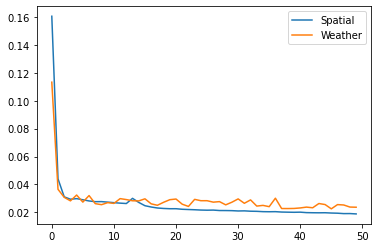

In [11]:
plt.figure()
plt.plot(spatial_losses_individual[0],label = "Spatial")
plt.plot(weather_losses_individual[0],label = "Weather")
plt.legend()

In [12]:
epsilon = 0.3
example = True
multi = False
spatial_task = False

checkup = Checkup()
Display_Score(model_weather,test_loader_weather,epsilon,example,multi,spatial_task)
 

Data tensor([[0.5400, 0.4300, 0.5200]])
Target tensor([1.])
Prediction tensor([0.7009])
Data tensor([[0.5000, 0.5200, 0.5300]])
Target tensor([1.])
Prediction tensor([0.9970])
Data tensor([[0.6000, 0.5900, 0.5500]])
Target tensor([1.])
Prediction tensor([0.9973])
Data tensor([[0.2000, 0.1500, 0.2600]])
Target tensor([1.])
Prediction tensor([0.9557])
Data tensor([[0.3800, 0.2900, 0.2600]])
Target tensor([1.])
Prediction tensor([0.9432])
Data tensor([[0.2500, 0.3700, 0.2500]])
Target tensor([1.])
Prediction tensor([0.7361])
Data tensor([[0.1000, 0.2400, 0.1300]])
Target tensor([1.])
Prediction tensor([0.6780])
Data tensor([[0.3300, 0.3600, 0.2600]])
Target tensor([1.])
Prediction tensor([0.9917])
Data tensor([[0.4100, 0.4400, 0.5200]])
Target tensor([1.])
Prediction tensor([0.9160])
Data tensor([[0.5800, 0.6300, 0.6500]])
Target tensor([1.])
Prediction tensor([0.9866])
Data tensor([[0.4200, 0.2700, 0.4200]])
Target tensor([1.])
Prediction tensor([0.1167])
Data tensor([[0.2100, 0.1500, 0.

In [13]:
epsilon = 0.3
example = True
multi = False
spatial_task = True

checkup = Checkup()
Display_Score(model_space,test_loader_space,epsilon,example,multi,spatial_task)

Data tensor([[0.9500, 0.8400]])
Target tensor([1.])
Prediction tensor([0.9983])
Data tensor([[0.2500, 0.1200]])
Target tensor([1.])
Prediction tensor([0.9834])
Data tensor([[0.9600, 0.8600]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.5700, 0.4700]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.4600, 0.4100]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.1300, 0.0700]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.2500, 0.1500]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.3300, 0.3500]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.7800, 0.6400]])
Target tensor([1.])
Prediction tensor([0.6949])
Data tensor([[0.2000, 0.2700]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.6900, 0.6700]])
Target tensor([1.])
Prediction tensor([0.9994])
Data tensor([[0.3700, 0.2200]])
Target tensor([1.])
Prediction tensor([0.4550])
Data tensor([[0.0600, 0.1300]])
Target t

In [14]:
def training_individual_interleaved(Epoch,Nodes_Second,Nodes_Third,train_loader_weather,val_loader_weather,test_loader_weather,train_loader_space,val_loader_space,test_loader_space):
        
        
    Input_Dimension = 3
    model_weather = Net_Individual(input_dimension=3,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    criterion = nn.BCEWithLogitsLoss()
    


    losses_weather = []
    val_losses_weather = []
    
    losses_space = []
    val_losses_space = []

    for epoch in range(Epoch):

        loss = 0
        val_loss = 0 

        for x_batch, y_batch in train_loader_weather:
            x_batch = x_batch[:,2:5]

            optimizer_weather.zero_grad()
            output = model_weather(x_batch).squeeze(1)

            output_loss = criterion(output,y_batch)
            output_loss.backward()
            optimizer_weather.step()

            loss += output_loss.detach().numpy()
        losses_weather.append(loss/len(train_loader_weather))

        with torch.no_grad():
            for x_val, y_val in val_loader_weather:
                model_weather.eval() 
                x_val = x_val[:,2:5]
                yhat = model_weather(x_val).squeeze(1)
                val_loss += criterion(yhat,y_val)
            val_losses_weather.append(val_loss.item()/len(val_loader_weather))
            
        
        
        
        model_space.fc2[0].weight = model_weather.fc2[0].weight
        model_space.fc3[0].weight = model_weather.fc3[0].weight

        for param in model_space.fc2.parameters():
            param.requires_grad = False

        for param in model_space.fc3.parameters():
            param.requires_grad = False
        
        
        loss = 0
        val = 0 

        for x_batch, y_batch in train_loader_space:
            x_batch = x_batch[:,0:2]
            

            optimizer_space.zero_grad()
            output = model_space(x_batch).squeeze(1)

            output_loss = criterion(output,y_batch)
            output_loss.backward()
            optimizer_space.step()

            loss += output_loss.detach().numpy()
        losses_space.append(loss/len(train_loader_space))

        with torch.no_grad():
            for x_val, y_val in val_loader_space:
                model_space.eval() 
                x_val = x_val[:,0:2]
                
                yhat = model_space(x_val).squeeze(1)
                val_loss += criterion(yhat,y_val)
            val_losses_space.append(val_loss.item()/len(val_loader_space))
    return model_space,val_losses_space,model_weather,val_losses_weather

In [15]:
model_space_interleaved,val_losses_space_interleaved,model_weather_interleaved,val_losses_weather_interleaved = training_individual_interleaved(EPOCH,Nodes_Second,Nodes_Third,train_loader_weather,val_loader_weather,test_loader_weather,train_loader_space,val_loader_space,test_loader_space)


In [16]:
print(len(spatial_losses_individual[0]))
print(len(val_losses_space_interleaved))

50
50


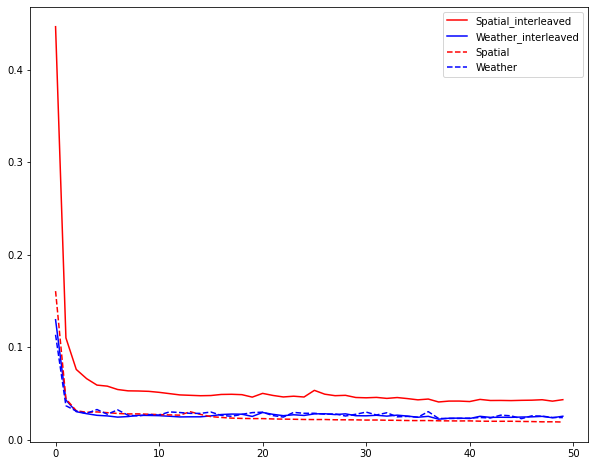

In [17]:
epoch = [i for i in range(EPOCH)]
plt.figure(figsize = (10,8))
plt.plot(epoch,val_losses_space_interleaved,color = "r",label = "Spatial_interleaved")
plt.plot(epoch,val_losses_weather_interleaved,color = "b",label = "Weather_interleaved")
plt.plot(epoch,spatial_losses_individual[0],"--",color = "r",label = "Spatial")
plt.plot(epoch,weather_losses_individual[0],"--",color = "b",label = "Weather")
plt.legend()

# WITH FIRST SPATIAL THEN CONCEPTUAL

In [18]:
def training_individual_interleaved(Epoch,Nodes_Second,Nodes_Third,train_loader_weather,val_loader_weather,test_loader_weather,train_loader_space,val_loader_space,test_loader_space):
        
        
    Input_Dimension = 3
    model_weather = Net_Individual(input_dimension=3,nodes_second = Nodes_Second,nodes_third = Nodes_Third,nodes_output = 1)  
    optimizer_weather = torch.optim.Adam(model_weather.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    Input_Dimension = 2
    model_space = Net_Individual(Input_Dimension ,Nodes_Second,Nodes_Third,1)    
    optimizer_space = torch.optim.Adam(model_space.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    criterion = nn.BCEWithLogitsLoss()
    


    losses_weather = []
    val_losses_weather = []
    
    losses_space = []
    val_losses_space = []

    for epoch in range(Epoch):



        loss = 0
        val_loss = 0 

        for x_batch, y_batch in train_loader_space:
            x_batch = x_batch[:,0:2]
            

            optimizer_space.zero_grad()
            output = model_space(x_batch).squeeze(1)

            output_loss = criterion(output,y_batch)
            output_loss.backward()
            optimizer_space.step()

            loss += output_loss.detach().numpy()
        losses_space.append(loss/len(train_loader_space))

        with torch.no_grad():
            for x_val, y_val in val_loader_space:
                model_space.eval() 
                x_val = x_val[:,0:2]
                
                yhat = model_space(x_val).squeeze(1)
                val_loss += criterion(yhat,y_val)
            val_losses_space.append(val_loss.item()/len(val_loader_space))

        
        model_weather.fc2[0].weight = model_space.fc2[0].weight
        model_weather.fc3[0].weight = model_space.fc3[0].weight

        for param in model_weather.fc2.parameters():
            param.requires_grad = False

        for param in model_weather.fc3.parameters():
            param.requires_grad = False
        

        loss = 0
        val_loss = 0 

        for x_batch, y_batch in train_loader_weather:
            x_batch = x_batch[:,2:5]

            optimizer_weather.zero_grad()
            output = model_weather(x_batch).squeeze(1)

            output_loss = criterion(output,y_batch)
            output_loss.backward()
            optimizer_weather.step()

            loss += output_loss.detach().numpy()
        losses_weather.append(loss/len(train_loader_weather))

        with torch.no_grad():
            for x_val, y_val in val_loader_weather:
                model_weather.eval() 
                x_val = x_val[:,2:5]
                yhat = model_weather(x_val).squeeze(1)
                val_loss += criterion(yhat,y_val)
            val_losses_weather.append(val_loss.item()/len(val_loader_weather))
            
        
        
        
        
    return model_space,val_losses_space,model_weather,val_losses_weather

In [19]:
model_space_interleaved_first,val_losses_space_interleaved_first,model_weather_interleaved_first,val_losses_weather_interleaved_first = training_individual_interleaved(EPOCH,Nodes_Second,Nodes_Third,train_loader_weather,val_loader_weather,test_loader_weather,train_loader_space,val_loader_space,test_loader_space)

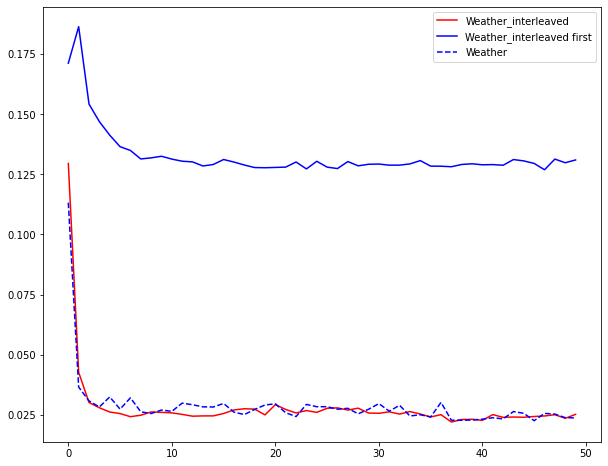

In [20]:
epoch = [i for i in range(EPOCH)]
plt.figure(figsize = (10,8))
#plt.plot(epoch,val_losses_space_interleaved_first,color = "r",label = "Spatial_interleaved")
plt.plot(epoch,val_losses_weather_interleaved,color = "r",label = "Weather_interleaved")
plt.plot(epoch,val_losses_weather_interleaved_first,color = "b",label = "Weather_interleaved first")

#plt.plot(epoch,spatial_losses_individual[0],"--",color = "r",label = "Spatial")
plt.plot(epoch,weather_losses_individual[0],"--",color = "b",label = "Weather")
plt.legend()